/Users/kayadetunji/anaconda3/envs/kaymacmini/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kayadetunji/anaconda3/envs/kaymacmini/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kayadetunji/anaconda3/envs/kaymacmini/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kayadetunji/anaconda3/envs/kaymacmini/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

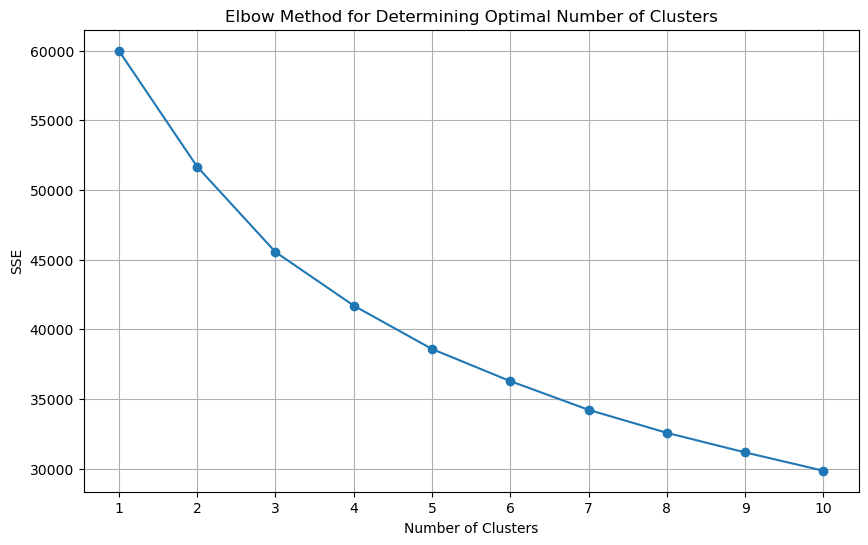

In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/mdscan-master/carbon/Carbon Emission.csv')
# Selecting a subset of numerical features for clustering
numerical_features = df.select_dtypes(include=['int64', 'float64']).drop(['CarbonEmission'], axis=1)

# Scaling the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Elbow method to determine the optimal number of clusters
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_features)
    sse[k] = kmeans.inertia_  # Sum of squared distances to closest cluster center

# Plotting the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Handle missing values for 'Vehicle Type' by replacing them with 'unknown'
df['Vehicle Type'].fillna('unknown', inplace=True)

# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the target variable
y = df['CarbonEmission']

# Define the features
X = df.drop(['CarbonEmission'], axis=1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the models
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=0),
    "Random Forest": RandomForestRegressor(random_state=0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=0)
}

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', model)])
    model_pipeline.fit(X_train, y_train)
    predictions = model_pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, r2, predictions

# Evaluate each model
results = {}
predictions = {}
for name, model in models.items():
    mse, r2, model_predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = (mse, r2)
    predictions[name] = model_predictions

results



{'Decision Tree': (589889.1745, 0.42779216801404785),
 'Random Forest': (298227.36456715, 0.7107117046816511),
 'Gradient Boosting': (270796.08684621035, 0.7373207570796849)}

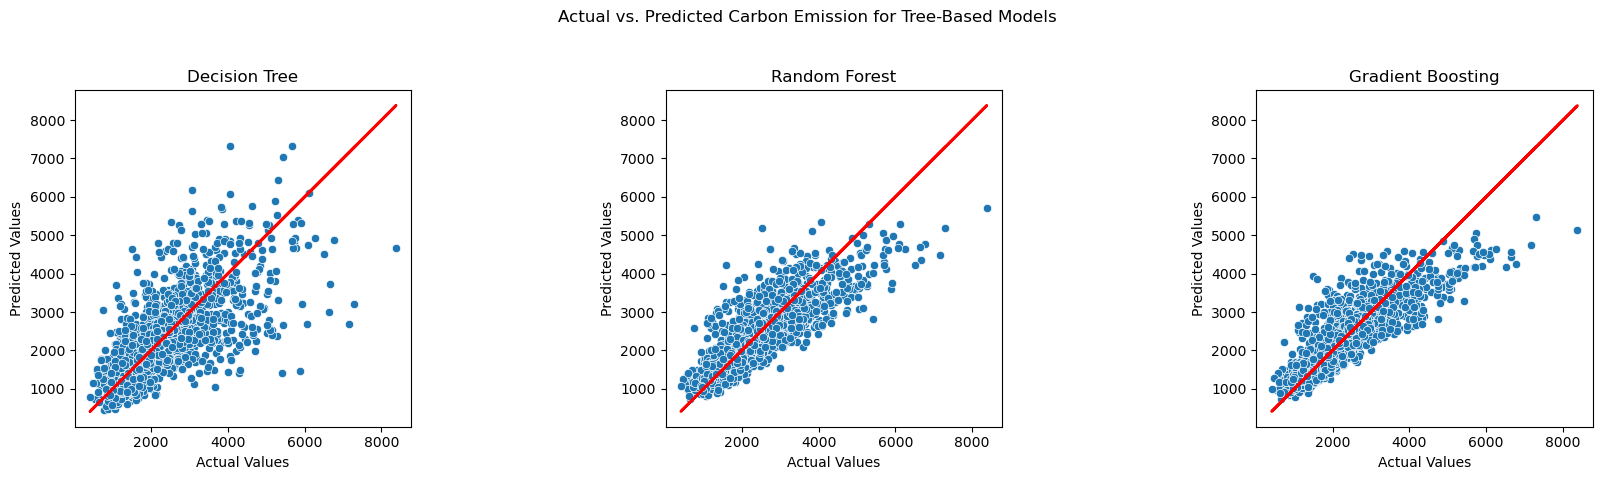

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model_predictions) in zip(axs, predictions.items()):
    sns.scatterplot(x=y_test, y=model_predictions, ax=ax)
    ax.plot(y_test, y_test, color="red", linewidth=2) # Perfect prediction line
    ax.set_title(name)
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_aspect('equal', 'box')

fig.suptitle('Actual vs. Predicted Carbon Emission for Tree-Based Models')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [6]:
df.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,unknown,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,unknown,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,unknown,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


In [7]:
import json

# Function to convert string representation of list to actual list
def string_to_list(string):
    try:
        return json.loads(string.replace("\'", "\""))
    except json.decoder.JSONDecodeError:
        return []

# Apply this function to 'Cooking_With' and 'Recycling' columns
df['Cooking_With'] = df['Cooking_With'].apply(string_to_list)
df['Recycling'] = df['Recycling'].apply(string_to_list)

# Function to one-hot encode lists in specified columns
def one_hot_encode_lists(df, column):
    # Get the union of all unique values in the lists of the column
    unique_values = set(item for sublist in df[column].tolist() for item in sublist)
    # Create a column for each unique value
    for value in unique_values:
        df[f"{column}_{value}"] = df[column].apply(lambda x: 1 if value in x else 0)
    return df

# Apply one-hot encoding to 'Cooking_With' and 'Recycling' columns
df = one_hot_encode_lists(df, 'Cooking_With')
df = one_hot_encode_lists(df, 'Recycling')

# Now, drop the original 'Cooking_With' and 'Recycling' columns
df.drop(['Cooking_With', 'Recycling'], axis=1, inplace=True)

# Re-select categorical columns (excluding the original 'Cooking_With' and 'Recycling' columns)
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in ['Cooking_With', 'Recycling']]

# Update the preprocessor with the new categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

# Redefine the features (X) and target (y) with the updated dataframe
X = df.drop(['CarbonEmission'], axis=1)
y = df['CarbonEmission']

# Splitting the dataset into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Re-evaluate each model with the updated dataset
updated_results = {}
updated_predictions = {}
for name, model in models.items():
    mse, r2, model_predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
    updated_results[name] = (mse, r2)
    updated_predictions[name] = model_predictions

updated_results


{'Decision Tree': (609067.15425, 0.4091890291720449),
 'Random Forest': (302835.268178215, 0.7062419184077757),
 'Gradient Boosting': (274600.06288439943, 0.7336308014476229)}

In [8]:
df.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,...,CarbonEmission,Cooking_With_Microwave,Cooking_With_Grill,Cooking_With_Oven,Cooking_With_Stove,Cooking_With_Airfryer,Recycling_Metal,Recycling_Glass,Recycling_Paper,Recycling_Plastic
0,overweight,female,pescatarian,daily,coal,public,unknown,often,230,frequently,...,2238,0,0,1,1,0,1,0,0,0
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,unknown,often,114,rarely,...,1892,1,0,0,1,0,1,0,0,0
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,...,2595,1,0,1,0,0,1,0,0,0
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,unknown,sometimes,157,rarely,...,1074,1,1,0,0,1,1,1,1,1
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,...,4743,0,0,1,0,0,0,0,1,0


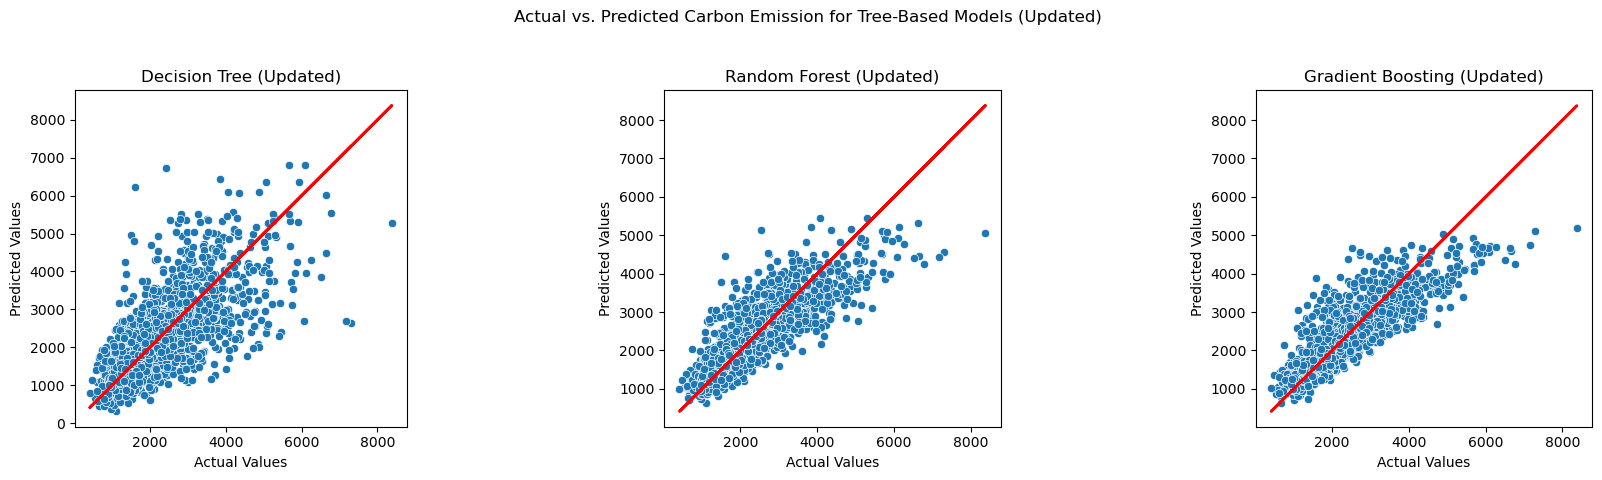

In [9]:
# Plotting the correlation between actual and predicted values for each updated model
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model_predictions) in zip(axs, updated_predictions.items()):
    sns.scatterplot(x=y_test, y=model_predictions, ax=ax)
    ax.plot(y_test, y_test, color="red", linewidth=2) # Perfect prediction line
    ax.set_title(name + " (Updated)")
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_aspect('equal', 'box')

fig.suptitle('Actual vs. Predicted Carbon Emission for Tree-Based Models (Updated)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()
